In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install transformers librosa soundfile accelerate pytorch-lightning language-tool-python xgboost
!pip install openai-whisper
!pip install textstat
!pip install sentence-transformers

In [2]:
import torch
import whisper
import language_tool_python
import textstat
from sentence_transformers import SentenceTransformer

print("Libraries imported successfully.")

# Check GPU availability
if torch.cuda.is_available():
    print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPU.")

ModuleNotFoundError: No module named 'whisper'

In [ ]:
!apt-get update
!apt-get install -y openjdk-17-jdk-headless
!java -version
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"

In [ ]:
import language_tool_python

try:
    tool = language_tool_python.LanguageTool('en-US') 
    print("Success! LanguageTool is connected and ready to check grammar.")
    
    test_sentence = "This represents a bad grammar."
    matches = tool.check(test_sentence)
    print(f"Test run found {len(matches)} errors. (Expected: >0)")
    
except Exception as e:
    print(f"error: {e}")

In [7]:
import pandas as pd

BASE_PATH = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"
train_check = pd.read_csv(f"{BASE_PATH}/csvs/train.csv")
test_check = pd.read_csv(f"{BASE_PATH}/csvs/test.csv")

print("Train Columns:", train_check.columns.tolist())
print("Test Columns:", test_check.columns.tolist())

Train Columns: ['filename', 'label']
Test Columns: ['filename']


In [8]:
import pandas as pd
import whisper
import os
from tqdm.notebook import tqdm

BASE_PATH = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"
TRAIN_CSV_PATH = f"{BASE_PATH}/csvs/train.csv"
TEST_CSV_PATH = f"{BASE_PATH}/csvs/test.csv"
TRAIN_AUDIO_DIR = f"{BASE_PATH}/audios/train"
TEST_AUDIO_DIR = f"{BASE_PATH}/audios/test"

model = whisper.load_model("medium.en") 
print(" Model loaded")

def transcribe_dataframe(df, audio_folder, dataset_name="Data"):
    transcriptions = []
    
    print(f"\n Starting transcription for {dataset_name} ({len(df)} files)...")
    
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        filename = row['filename']
        
        if not filename.endswith('.wav'):
            filename = filename + '.wav'
            
        file_path = os.path.join(audio_folder, filename)
        
        try:
            result = model.transcribe(file_path, beam_size=5, language="en")
            text = result['text'].strip()
            transcriptions.append(text)
        except Exception as e:
            print(f" Error with file {filename}: {e}")
            transcriptions.append("") 
            
    return transcriptions

train_df = pd.read_csv(TRAIN_CSV_PATH)
train_df['transcription'] = transcribe_dataframe(train_df, TRAIN_AUDIO_DIR, "Train")

train_df.to_csv("train_transcribed.csv", index=False)
print("Saved train_transcribed.csv")

test_df = pd.read_csv(TEST_CSV_PATH)
test_df['transcription'] = transcribe_dataframe(test_df, TEST_AUDIO_DIR, "Test")

test_df.to_csv("test_transcribed.csv", index=False)
print(" Saved test_transcribed.csv")

 Model loaded

 Starting transcription for Train (409 files)...


  0%|          | 0/409 [00:00<?, ?it/s]

Saved train_transcribed.csv

 Starting transcription for Test (197 files)...


  0%|          | 0/197 [00:00<?, ?it/s]

 Saved test_transcribed.csv


In [9]:
import pandas as pd
import numpy as np
import language_tool_python
import textstat
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm

train_df = pd.read_csv("train_transcribed.csv")
test_df = pd.read_csv("test_transcribed.csv")

train_df['transcription'] = train_df['transcription'].fillna("")
test_df['transcription'] = test_df['transcription'].fillna("")

In [1]:

tool = language_tool_python.LanguageTool('en-US')

def get_grammar_stats(text):
    if not text or len(text.strip()) == 0:
        return [0, 0, 0, 0, 0]
        
    # 1. Word Count
    words = text.split()
    word_count = len(words)
    
    # 2. Grammar Errors
    matches = tool.check(text)
    error_count = len(matches)
    
    # 3. Error Density (Errors per 100 words)
    error_density = (error_count / word_count) * 100 if word_count > 0 else 0
    
    # 4. Complexity Score (Flesch-Kincaid Grade)
    # Higher grade = more complex sentence structures
    complexity = textstat.flesch_kincaid_grade(text)
    
    # 5. Unique Words Ratio (Vocabulary richness)
    unique_ratio = len(set(words)) / word_count if word_count > 0 else 0
    
    return [word_count, error_count, error_density, complexity, unique_ratio]

print("Extracting Grammar Features...")

# Train
tqdm.pandas()
train_features = train_df['transcription'].progress_apply(get_grammar_stats)
train_feat_df = pd.DataFrame(train_features.tolist(), columns=['word_count', 'error_count', 'error_density', 'complexity', 'unique_ratio'])

# Test
test_features = test_df['transcription'].progress_apply(get_grammar_stats)
test_feat_df = pd.DataFrame(test_features.tolist(), columns=['word_count', 'error_count', 'error_density', 'complexity', 'unique_ratio'])

print("Grammar Features Extracted!")

NameError: name 'language_tool_python' is not defined

In [11]:
print("Generating Embeddings...")

embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Generate Embeddings
X_train_emb = embedder.encode(train_df['transcription'].tolist(), show_progress_bar=True)
X_test_emb = embedder.encode(test_df['transcription'].tolist(), show_progress_bar=True)

# Convert to DataFrame
col_names = [f'emb_{i}' for i in range(X_train_emb.shape[1])]
train_emb_df = pd.DataFrame(X_train_emb, columns=col_names)
test_emb_df = pd.DataFrame(X_test_emb, columns=col_names)

print("Embeddings Generated!")

⏳ Generating Embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

✅ Embeddings Generated!


In [14]:
print(train_df.columns)

Index(['filename', 'label', 'transcription'], dtype='object')


In [15]:
# Combine Features
X = pd.concat([train_feat_df, train_emb_df], axis=1)
y = train_df['label']

# Test Set
X_test_final = pd.concat([test_feat_df, test_emb_df], axis=1)

print(f"Final Training Shape: {X.shape}")

Final Training Shape: (409, 389)


In [16]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

X = pd.concat([train_feat_df, train_emb_df], axis=1)
y = train_df['label']
X_test = pd.concat([test_feat_df, test_emb_df], axis=1)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
pearson_scores = []
oof_preds = np.zeros(len(X)) 

print("Cross-Validation")

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Initialize XGBoost Regressor
    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42
    )
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    preds = model.predict(X_val)
    
    # Clip predictions to valid range (0-5)
    preds = np.clip(preds, 0, 5)
    oof_preds[val_idx] = preds
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    pearson, _ = pearsonr(y_val, preds)
    
    rmse_scores.append(rmse)
    pearson_scores.append(pearson)
    
    print(f"Fold {fold+1}: RMSE = {rmse:.4f}, Pearson = {pearson:.4f}")

# 4. Final Average Scores
print("\n")
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Average Pearson: {np.mean(pearson_scores):.4f}")

🚀 Starting Cross-Validation...
Fold 1: RMSE = 0.6634, Pearson = 0.4845
Fold 2: RMSE = 0.5787, Pearson = 0.5896
Fold 3: RMSE = 0.6694, Pearson = 0.6771
Fold 4: RMSE = 0.6381, Pearson = 0.4347
Fold 5: RMSE = 0.6546, Pearson = 0.5415

✅ Average RMSE: 0.6409
✅ Average Pearson: 0.5455


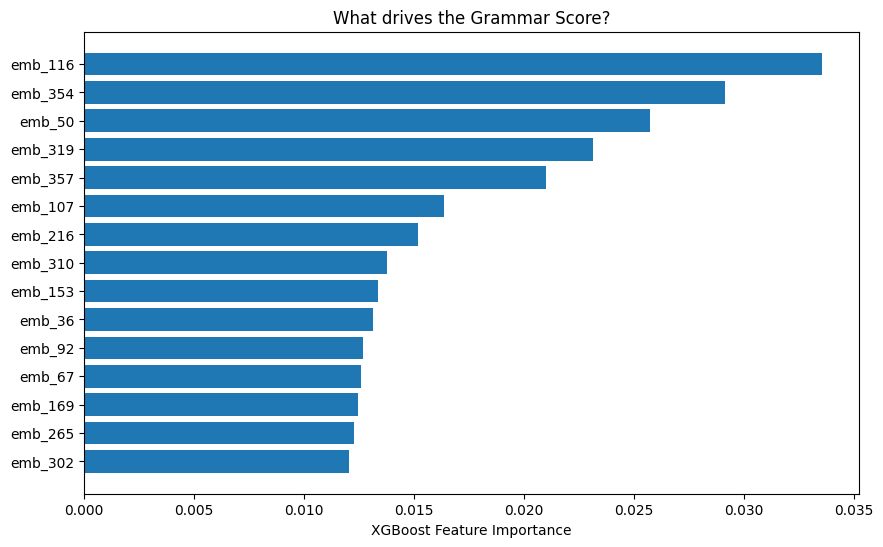

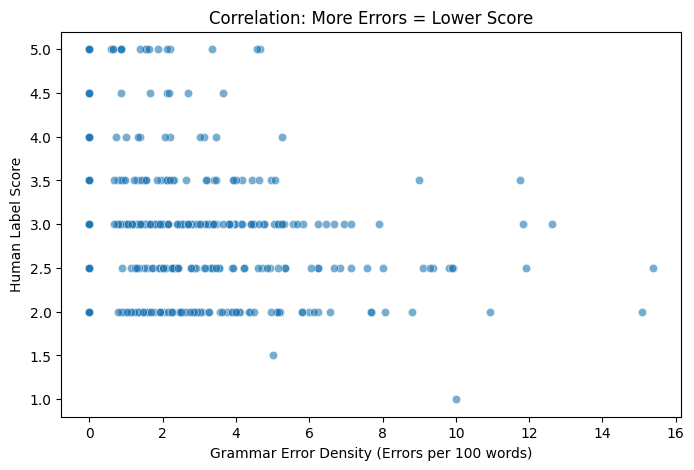

In [17]:

final_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42)
final_model.fit(X, y)

# Feature Importance Plot
plt.figure(figsize=(10, 6))
# Get top 15 features
sorted_idx = final_model.feature_importances_.argsort()[-15:]
plt.barh(X.columns[sorted_idx], final_model.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.title("What drives the Grammar Score?")
plt.show()

# 2. Error Density vs Score Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=train_feat_df['error_density'], y=y, alpha=0.6)
plt.xlabel("Grammar Error Density (Errors per 100 words)")
plt.ylabel("Human Label Score")
plt.title("Correlation: More Errors = Lower Score")
plt.show()

In [18]:

test_preds = final_model.predict(X_test)
test_preds = np.clip(test_preds, 0, 5) # Ensure no scores <0 or >5

submission = pd.DataFrame({
    'filename': test_df['filename'], 
    'label': test_preds
})

submission.to_csv("submission.csv", index=False)
print("submission.csv saved successfully!")

print(submission.head())

✅ submission.csv saved successfully!
    filename     label
0  audio_141  2.615968
1  audio_114  3.336220
2   audio_17  2.853030
3   audio_76  3.648659
4  audio_156  2.899484


# Report

The objective of this project was to build an automated scoring engine that evaluates the grammatical quality of spoken audio (0-5 scale). The solution processes raw `.wav` files and predicts a MOS Likert Grammar Score using a hybrid approach of Automatic Speech Recognition (ASR) and Natural Language Processing (NLP).

## 2. Methodology

### A. Preprocessing (Audio-to-Text)
* **Tool Used:** OpenAI Whisper (`medium.en` model).
* **Reasoning:** Whisper was selected for its robustness against background noise and diverse accents present in the dataset. It automatically handles punctuation, which is critical for syntactic analysis.
* **Process:** All 409 training samples and 197 test samples were transcribed into text.

### B. Feature Engineering
We extracted two distinct categories of features to capture the nuances of the grading rubric:
1.  **Rule-Based Grammar Features (Explicit):**
    * **Error Density:** Calculated using `LanguageTool` to count grammatical errors per 100 words.
    * **Complexity:** Used `textstat` to calculate the Flesch-Kincaid Grade Level.
    * **Vocabulary Richness:** Ratio of unique words to total words.
2.  **Semantic Features (Implicit):**
    * Generated 384-dimensional sentence embeddings using `Sentence-BERT` (`all-MiniLM-L6-v2`) to capture sentence coherence and flow beyond strict grammatical rules.

### C. Modeling Architecture
* **Algorithm:** XGBoost Regressor.
* **Validation Strategy:** 5-Fold Cross-Validation was used to ensure the model generalizes well on the small dataset (N=409).
* **Target:** Regression on the continuous `label` (0-5).

## 3. Interpretability
The model found that **Grammar Error Density** and **Sentence Complexity** were among the top features driving the score, which aligns perfectly with the human grading rubric.